#### **How to Approximate a Piecewise Defined Function Using a Feedforward Neural Network with One Layer**
**Authors** : Eliot Guez 

In this notebook, we will explore how to implement and train a neural network to approximate a piecewise defined function using PyTorch. The process will involve the following steps:
1. **Introduction to the Function:**  
We will start by defining the piecewise function we aim to approximate. This function is derived from an exam question in my deep learning coursework, where I theoretically determined the number of neurons and the coefficients needed for the neural network to learn the function.
2. **Model Definition and Initialization:**  
Next, we will create a simple feedforward neural network (MLP) with one hidden layer. We will initialize the network with theoretical weights and biases to demonstrate that the network can reproduce the function effectively.
3. **Training and Optimization:**  
Finally, we will train the neural network using two different learning rates to optimize the convergence and evaluate the performance of the model.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

---
#### 1. **Introduction to the function**
---

In [2]:
def piecewise_linear_function(x):
    return (
        2 * (torch.relu(x - 1) - torch.relu(x - 2))
        - 2 * (torch.relu(x - 4) - torch.relu(x - 5))
        + 2 * (torch.relu(x - 7) - torch.relu(x - 8))
        - 2 * (torch.relu(x - 10) - torch.relu(x - 11))
    )

In [3]:
# Generate the data
x_train = torch.linspace(-5, 15, 10000).unsqueeze(1)  # 10 000 points between -5 and 15
y_train = piecewise_linear_function(x_train)

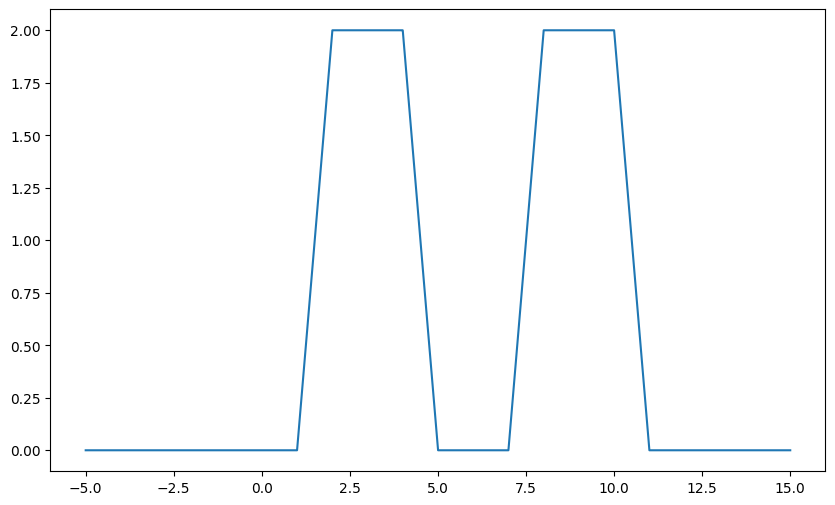

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, label="piecewise_linear_function(x)")
plt.show()

**Theoretically, the 8 neurons are:**

1. **Weights of the first layer (fc1):**
   - `tensor([[ 1.0], [1.0], [ 1.0], [1.0], [ 1.0], [1.0], [ 1.0], [1.0]])`

2. **Biases of the first layer (`fc1`) :**
   - `tensor([1.0, 2.0, 4.0, 5.0, 7.0, 8.0, 10.0, 11.0])`

3. **Weights of the second layer (`fc2`) :**
   - `tensor([[2.0, -2.0, -2.0, 2.0, 2.0, -2.0, -2.0, 2.0]])`

4. **Biases of the second layer (`fc2`) :**
   - `tensor([0.0])`


---
#### 2. **Model Definition and Initialization**
---

**Creation of the model**

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(1, 8)  # 8 neurons in the first hidden layer
        self.fc2 = nn.Linear(8, 1)  # 1 output neuron

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [6]:
model = SimpleMLP()

# Initialize the weights and biases
with torch.no_grad():
    model.fc1.weight.data = torch.tensor(
        [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
    )
    model.fc1.bias.data = torch.tensor(
        [-1.0, -2.0, -4.0, -5.0, -7.0, -8.0, -10.0, -11.0]
    )
    model.fc2.weight.data = torch.tensor([[2.0, -2.0, -2.0, 2.0, 2.0, -2.0, -2.0, 2.0]])
    model.fc2.bias.data = torch.tensor([0.0])
print("Weights of the first layer (fc1) after initialization:", model.fc1.weight.data)
print("\nBiases of the first layer (fc1) after initialization:", model.fc1.bias.data)
print(
    "\nWeights of the second layer (fc2) after initialization:", model.fc2.weight.data
)
print("\nBiases of the second layer (fc2) after initialization:", model.fc2.bias.data)

Weights of the first layer (fc1) after initialization: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

Biases of the first layer (fc1) after initialization: tensor([ -1.,  -2.,  -4.,  -5.,  -7.,  -8., -10., -11.])

Weights of the second layer (fc2) after initialization: tensor([[ 2., -2., -2.,  2.,  2., -2., -2.,  2.]])

Biases of the second layer (fc2) after initialization: tensor([0.])


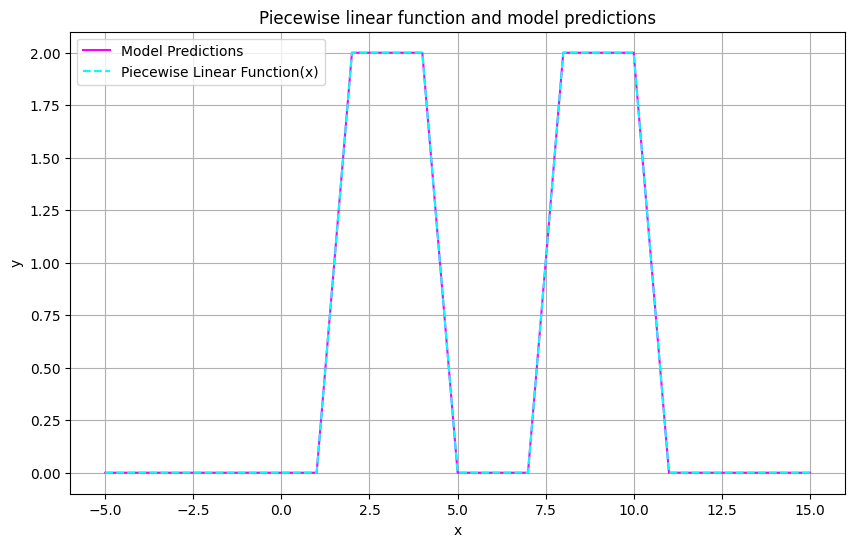

In [7]:
# Pass the data through the model
model.eval()
with torch.no_grad():
    y_pred = model(x_train)

# Plot the model predictions
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_pred, label="Model Predictions", color="magenta")
plt.plot(
    x_train, y_train, label="Piecewise Linear Function(x)", linestyle="--", color="cyan"
)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Piecewise linear function and model predictions")
plt.legend()
plt.grid(True)
plt.show()

Let's now try to optimize the neural network to get real results

---
#### 3. **Training and Optimization**
--- 


Without using mini-batches, the algorithm struggles to achieve good results. By experimenting with various batch sizes, I found that the best performance is achieved with a batch size of 64.

In [9]:
train_dataset = TensorDataset(x_train, y_train)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [79]:
model = SimpleMLP()
criterion = nn.MSELoss()  # standard loss for regression problems

In [80]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

# Training the model
epochs = 150
losses = []
early_stopping_threshold = 0.01
patience = 5
patience_counter = 0

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    losses.append(average_loss)

    if average_loss < early_stopping_threshold:
        print(f"Early stopping at epoch {epoch + 1}/{epochs}, Loss: {average_loss}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    losses.append(average_loss)

    if average_loss < early_stopping_threshold:
        print(f"Early stopping at epoch {epoch + 1}/{epochs}, Loss: {average_loss}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

# Eval the model
model.eval()
x_test = torch.linspace(-3, 15, 10000).unsqueeze(1)
y_test = piecewise_linear_function(x_test).detach().numpy()
y_pred = model(x_test).detach().numpy()

Epoch 10/150, Loss: 0.4222113754564581
Epoch 20/150, Loss: 0.42514927275835895
Epoch 30/150, Loss: 0.4028620941046709
Epoch 40/150, Loss: 0.3328785721581584
Epoch 50/150, Loss: 0.17687044906825683
Epoch 60/150, Loss: 0.12233809152017006
Epoch 70/150, Loss: 0.11406592924754841
Epoch 80/150, Loss: 0.10861575735000947
Epoch 90/150, Loss: 0.10524446833819247
Epoch 100/150, Loss: 0.05469428257237132
Epoch 110/150, Loss: 0.04327922272153746
Epoch 120/150, Loss: 0.04548243826891953
Epoch 130/150, Loss: 0.04123273221389078
Epoch 140/150, Loss: 0.04150092735969887
Epoch 150/150, Loss: 0.0383343322964284
Epoch 10/150, Loss: 0.030711277135121173
Epoch 20/150, Loss: 0.0313186918165142
Epoch 30/150, Loss: 0.031503012026704774
Epoch 40/150, Loss: 0.03121115840352572
Epoch 50/150, Loss: 0.0307163597640995
Epoch 60/150, Loss: 0.031017041668450585
Epoch 70/150, Loss: 0.03076971926467535
Epoch 80/150, Loss: 0.030179527525703746
Epoch 90/150, Loss: 0.03045034364457971
Epoch 100/150, Loss: 0.0312219941527

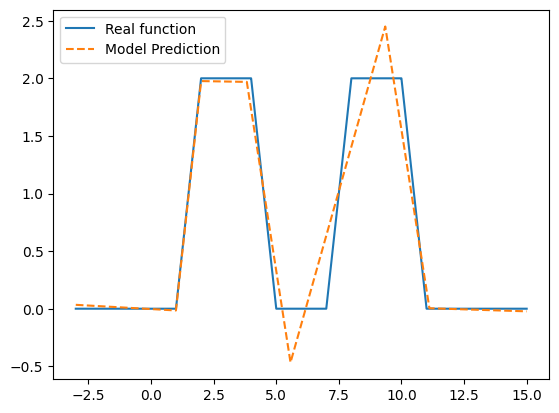

In [84]:
# Plot the model predictions
plt.plot(x_test, y_test, label="Real function")
plt.plot(x_test, y_pred, label="Model Prediction", linestyle="--")
plt.legend()
plt.show()

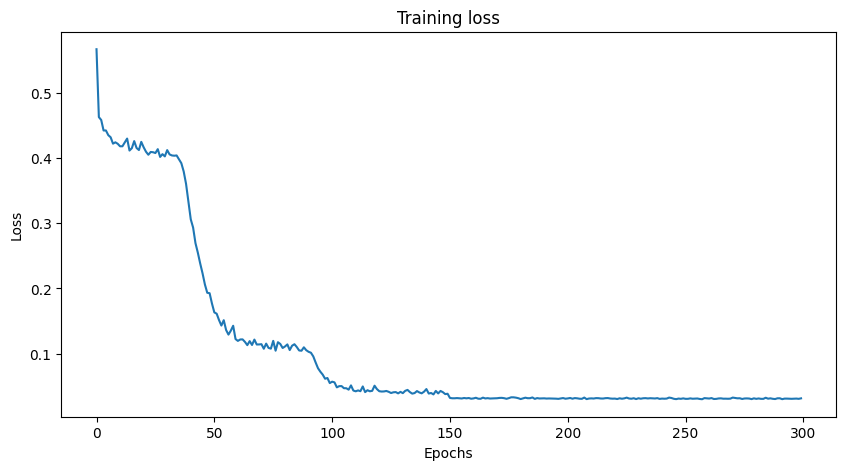

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(range(2 * epochs), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()

In [86]:
# Print the weights and biases of the model
print("Weights of the first layer (fc1):", model.fc1.weight.data)

print("\nBiases of the first layer (fc1):", model.fc1.bias.data)

print("\nWeights of the second layer (fc2):", model.fc2.weight.data)

print("\nBiases of the second layer (fc2):", model.fc2.bias.data)

Weights of the first layer (fc1): tensor([[-1.0829],
        [ 1.0271],
        [ 0.9887],
        [-0.5171],
        [-0.3758],
        [-0.2432],
        [ 0.8276],
        [-1.4792]])

Biases of the first layer (fc1): tensor([ 2.1406, -2.0881, -3.7846,  4.8375,  4.1770,  2.6891, -4.6111,  1.4775])

Weights of the second layer (fc2): tensor([[-1.1205, -0.7612, -1.4094, -4.1812,  3.5267,  0.2418,  2.6201,  1.3546]])

Biases of the second layer (fc2): tensor([5.2393])


We see that we have reached a local minimum. Indeed, to obtain a curve that more closely resembles the function we want to approximate, we would need to change all the parameters, as seen when we display the weights. Our optimizer will never move in that direction. Perhaps with different initializations and more luck, we might eventually converge to the theoretical weights with a network of 8 neurons.


What happen if we initialize with the solution ?

Epoch 10/150, Loss: 0.00022979737538457502
Epoch 20/150, Loss: 1.8577541455848483e-06
Epoch 30/150, Loss: 1.5163330879941625e-05
Epoch 40/150, Loss: 8.52271365018738e-06
Epoch 50/150, Loss: 4.756512079786252e-06
Epoch 60/150, Loss: 6.245999850743131e-05
Epoch 70/150, Loss: 0.00011696968879831298
Epoch 80/150, Loss: 8.009380087469326e-05
Epoch 90/150, Loss: 3.279680279697764e-05
Epoch 100/150, Loss: 0.00041629668136808503
Epoch 110/150, Loss: 6.143158872484023e-06
Epoch 120/150, Loss: 2.2026617847350297e-05
Epoch 130/150, Loss: 0.00021490718949654313
Epoch 140/150, Loss: 0.00010849594072921062
Epoch 150/150, Loss: 6.141568484837101e-06


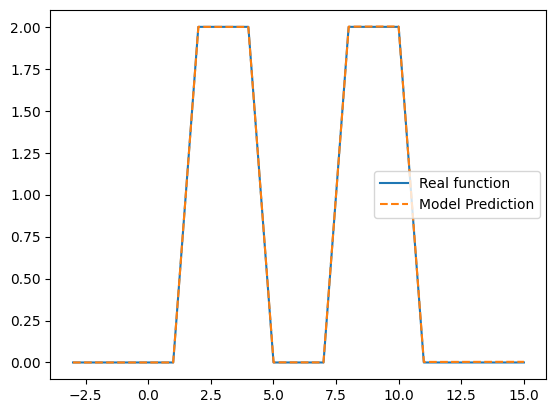

In [22]:
model = SimpleMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training the model
epochs = 150
losses = []
with torch.no_grad():
    model.fc1.weight.data = torch.tensor(
        [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
    )
    model.fc1.bias.data = torch.tensor(
        [-1.0, -2.0, -4.0, -5.0, -7.0, -8.0, -10.0, -11.0]
    )
    model.fc2.weight.data = torch.tensor([[2.0, -2.0, -2.0, 2.0, 2.0, -2.0, -2.0, 2.0]])
    model.fc2.bias.data = torch.tensor([0.0])

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    losses.append(average_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

# Eval the model
model.eval()
x_test = torch.linspace(-3, 15, 10000).unsqueeze(1)
y_test = piecewise_linear_function(x_test).detach().numpy()
y_pred = model(x_test).detach().numpy()

plt.plot(x_test, y_test, label="Real function")
plt.plot(x_test, y_pred, label="Model Prediction", linestyle="--")
plt.legend()
plt.show()

Epoch 1000/20000, Loss: 0.3536258339881897
Epoch 2000/20000, Loss: 0.3536069393157959
Epoch 3000/20000, Loss: 0.3536044657230377
Epoch 4000/20000, Loss: 0.353613018989563
Epoch 5000/20000, Loss: 0.3536246716976166
Epoch 6000/20000, Loss: 0.35360413789749146
Epoch 7000/20000, Loss: 0.35360419750213623
Epoch 8000/20000, Loss: 0.35360458493232727
Epoch 9000/20000, Loss: 0.3536057770252228
Epoch 10000/20000, Loss: 0.35361069440841675
Epoch 11000/20000, Loss: 0.3536044657230377
Epoch 12000/20000, Loss: 0.3536054790019989
Epoch 13000/20000, Loss: 0.35363587737083435
Epoch 14000/20000, Loss: 0.35360419750213623
Epoch 15000/20000, Loss: 0.3537345826625824
Epoch 16000/20000, Loss: 0.3554929494857788
Epoch 17000/20000, Loss: 0.3536040484905243
Epoch 18000/20000, Loss: 0.35360580682754517
Epoch 19000/20000, Loss: 0.35360440611839294
Epoch 20000/20000, Loss: 0.35360395908355713


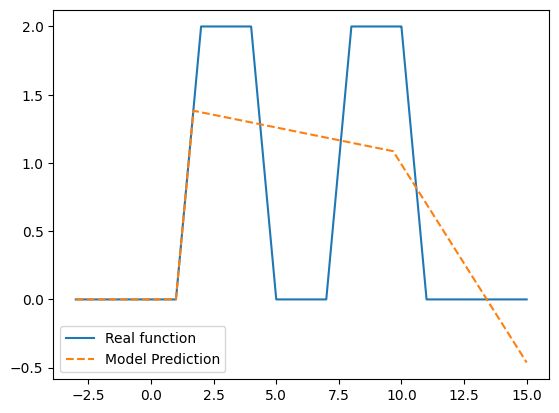

In [32]:
model = SimpleMLP()

# Définir la fonction de perte et l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

# Entraînement du modèle
epochs = 20000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Évaluation du modèle
model.eval()
x_test = torch.linspace(-3, 15, 10000).unsqueeze(1)
y_test = piecewise_linear_function(x_test).detach().numpy()
y_pred = model(x_test).detach().numpy()

plt.plot(x_test, y_test, label="Real function")
plt.plot(x_test, y_pred, label="Model Prediction", linestyle="--")
plt.legend()
plt.show()